# Détermination de communes survolées par une trajectoire

Un problème intéressant à partir d'une trajectoire d'un avion (que l'on peut récupérer par exemple par [ADS-B](http://www.xoolive.org/2016/05/10/playing-with-adsb-signals.html)) est de déterminer les communes qui voient leur territoire survolé par cette trajectoire. Ce calcul peut notamment servir à mesurer l'impact environnemental (émissions de polluants, impact sonore, etc.) du trafic aérien.

Les données concernées sont :

- les communes sont formées de polygones en coordonnées x-y (projection Lambert 93); on utilise ici la base [GEOFLA](http://professionnels.ign.fr/geofla) de l'IGN pour les communes d'Île-de-France;
- une trajectoire est formée d'échantillons, des quadruplets (t, x, y, z) pour le temps, l'abcisse, l'ordonnée et l'altitude barométrique.

Dans un contexte contraint par la performance, la méthode naïve consistant pour chaque point à tester son appartenance à un polygone (une commune) n'est pas raisonnable. On étudie ici l'organisation des données en quadtree.

## Présentation des données

In [1]:
import os.path
import fiona
from shapely.geometry import shape

fullpath = os.path.join(os.path.expanduser("~"), 'Documents', 'data',
                        'GEOFLA_2-0_COMMUNE_SHP_LAMB93_FXX_2015-07-01',
                        'GEOFLA', '1_DONNEES_LIVRAISON_2015',
                        'GEOFLA_2-0_SHP_LAMB93_FR-ED151',
                        'COMMUNE', 'COMMUNE.SHP')

idf = [p for p in fiona.open(fullpath)
       if p['properties']['NOM_REG']== 'ILE-DE-FRANCE']

shapes = []
for item in idf:
    s = shape(item['geometry'])
    if s.geom_type == "MultiPolygon":
        # seulement Châteaufort pour une raison bizarre...
        s = s[0]
    shapes.append(s)

print("{} communes en Île-de-France".format(len(idf)))

1299 communes en Île-de-France


On peut alors afficher les communes d'Île-de-France sur une carte:

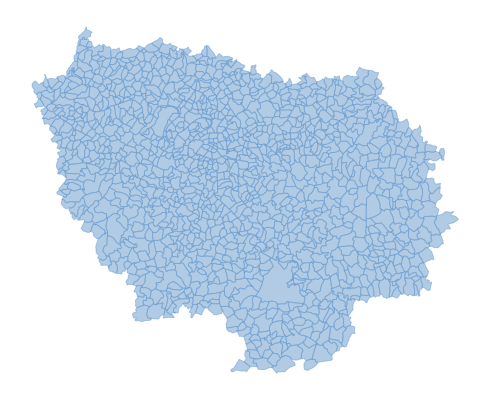

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from descartes import PolygonPatch

fig = plt.figure(figsize=(15, 7))
ax = fig.gca()

for s in shapes:
    ax.add_patch(PolygonPatch(s, fc='#6699cc', ec='#6699cc',
                              alpha=0.5, zorder=2))
    
bbox = ax.axis('scaled')
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

On utilise la trajectoire ci-jointe (prétraitée) d'un vol qui atterrit à Paris-Orly.  
On peut d'ores et déjà filtrer la trajectoire à tous les points en dessous de 5000 pieds.

In [3]:
import pandas as pd

traj = pd.read_pickle('../extra/trajectory.pkl')
# On s'intéresse à la trajectoire en dessous de 5000 pieds
traj = traj[traj.baroaltitude < 5000]

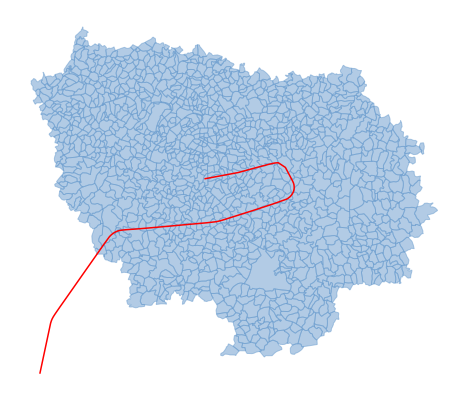

In [4]:
fig = plt.figure(figsize=(15, 7))
ax = fig.gca()

for s in shapes:
    ax.add_patch(PolygonPatch(s, fc='#6699cc', ec='#6699cc',
                              alpha=0.5, zorder=2))
    
ax.plot(traj.lamb93_x, traj.lamb93_y, '-r')

# Finitions
bbox = ax.axis('scaled')
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

## Structure de données

Un [quadtree](https://fr.wikipedia.org/wiki/Quadtree) est une structure arborescente dans laquelle chaque nœud a quatre fils. On subdivise récursivement chacun des nœuds quand il devient trop lourd.

Le cas d'utilisation classique de cette structure est un test d'appartenance. On souhaite tester si un élément est présent dans une structure de données énumérable. Au lieu de faire n tests d'égalité sur chacun des éléments de la structure, on fait quelques tests géométriques (autant que la profondeur de l'arbre) pour retrouver le nœud dans lequel devrait se trouver l'élément puis des tests d'égalité sur les éléments présents dans la feuille: le nombre de tests est alors borné.

Pour le cas d'étude qui nous préoccupe, on manipule des points et des polygones: on va alors placer des communes (polygones) dans un arbre (quadtree) ; puis pour chaque point à tester, on ne testera son appartenance qu'à un nombre borné de communes. Une commune n'étant pas un point, il faut bien prendre soin de dupliquer les communes dans plusieurs nœuds de l'arbre si besoin.

In [5]:
class Quadtree(object):
    """
    Quadtree qui permet d'insérer des polygones dans plusieurs
    sous-cellules.
    
    Création:
    >>> q = Quadtree(x_min, x_max, y_min, y_max)
    
    Insertion d'un polygone dans les bonnes feuilles du
    quadtree (parfois plusieurs):
    >>> q.insert(polygon)
    
    Le polygone doit être muni de l'opération `in_bbox`.
    
    Recherche d'une commune survolée par un point:
    >>> q.match((x, y))
    
    La méthode renvoie le premier polygone qui contient le
    point (x, y).
    
    """
    
    def __init__(self, x_min, x_max, y_min, y_max, size_max=8):
        """
        - x_min, x_max, y_min, y_max sont les bornes de la
          bounding box;
        - `dx`, `dy` sont les points médians;
        - `children` contient les sous-arbres;
        - `elements` contient les communes (si le nœud est une
          feuille);
        - `size` vaut la taille de `elements` si le nœud est une
          feuille, None sinon;
        - `size_max` borne la taille de `elements`.
        """
        self.x_min, self.x_max = x_min, x_max
        self.y_min, self.y_max = y_min, y_max
        self.dx = (x_min + x_max)/2
        self.dy = (y_min + y_max)/2
        self.children = []
        self.elements = []
        self.size = 0
        self.size_max = size_max
        
    def insert(self, element):
        if self.size is None:
            # IMPORTANT : les tests ne sont pas exclusifs!
            # On peut ajouter une commune à plusieurs sous-arbres
            if element.in_bbox(self.x_min, self.dx,
                               self.y_min, self.dy):
                self.children[0].insert(element)
            if element.in_bbox(self.dx, self.x_max,
                               self.y_min, self.dy):
                self.children[1].insert(element)
            if element.in_bbox(self.x_min, self.dx,
                               self.dy, self.y_max):
                self.children[2].insert(element)
            if element.in_bbox(self.dx, self.x_max,
                               self.dy, self.y_max):
                self.children[3].insert(element)
            return
        if self.size < self.size_max:
            # s'il y a encore de la place
            self.elements.append(element)
            self.size += 1
        else:
            # sinon on subdivise...
            self.children.append(Quadtree(self.x_min, self.dx,
                                          self.y_min, self.dy))
            self.children.append(Quadtree(self.dx, self.x_max,
                                          self.y_min, self.dy))
            self.children.append(Quadtree(self.x_min, self.dx,
                                          self.dy, self.y_max))
            self.children.append(Quadtree(self.dx, self.x_max,
                                          self.dy, self.y_max))
            self.size = None  # Le nœud n'est plus une feuille
            # puis on redispatche les éléments du nœud dans les fils
            for e in self.elements:
                self.insert(e)
            # on nettoie pour éviter les fuites...
            self.elements.clear()
            # sans oublier d'ajouter l'élément qui a tout déclenché
            self.insert(element)        
            
    def match(self, point):
        if self.size is not None:
            # si le nœud est une feuille, on recherche le 1er polygone
            for e in self.elements:
                if e.inside(point[0], point[1]):
                    return e
            # pas trouvé
            return None
        # on construit l'index du sous-arbre dans lequel se place le point
        idx = 0
        if point[1] >= self.dy:
            idx += 2
        if point[0] >= self.dx:
            idx += 1
        # puis on lance la recherche de manière récursive
        return self.children[idx].match(point)
    
    def plot(self, color="#999999"):
        """ À but illustratif ci-dessous """
        plt.plot([self.x_min, self.x_min, self.x_max,
                  self.x_max, self.x_min],
                 [self.y_min, self.y_max, self.y_max,
                  self.y_min, self.y_min],
                '-.' if color=="#999999" else '-',
                 lw=1 if color=="#999999" else 2,
                 color=color)
            

On peut à présent construire le quadtree sur la bounding box du plot précédent.

In [6]:
q = Quadtree(*bbox)

Le test d'appartenance d'un point à un polygone peut se découper en deux parties:

- la première peut se factoriser et s'exécuter à la création du polygone (constructeur `__init__`) ;
- la deuxième est différente pour chaque point à tester (méthode `inside`)

In [7]:
import numpy as np
from collections import Iterable

class Polygon(object):
    """Test if a point falls inside in a Polygon.

    >>> polyX = [0, 0, 1, 1]
    >>> polyY = [0, 1, 1, 0]
    >>> p = Polygon(polyX, polyY)
    >>> p.inside(0.5, 0.5)
    True
    >>> p.inside(1.5, 0.5)
    False
    >>> p.inside(-1.5, 0.5)
    False
    """

    def __init__(self, polyX, polyY):
        self.polycorners = len(polyX)
        self.constant = np.zeros(self.polycorners)
        self.multiple = np.zeros(self.polycorners)
        self.polyX, self.polyY = polyX, polyY
        j = self.polycorners - 1
        for i in range(self.polycorners):
            if polyY[j] == polyY[i]:
                self.constant[i] = polyX[i]
                self.multiple[i] = 0
            else:
                self.constant[i] = polyX[i]
                self.constant[i] -= (polyY[i]*polyX[j])/(polyY[j]-polyY[i])
                self.constant[i] += (polyY[i]*polyX[i])/(polyY[j]-polyY[i])
                self.multiple[i] = (polyX[j]-polyX[i])/(polyY[j]-polyY[i])
            j = i

    def inside(self, x, y):
        if not isinstance(x, Iterable):
            x, y = np.array([x]), np.array([y])
        else:
            x, y = np.array(x), np.array(y)
        j = self.polycorners - 1
        oddNodes = np.zeros_like(x, dtype=bool)
        for i in range(self.polycorners):
            tab1 = np.bitwise_and(self.polyY[i] < y, self.polyY[j] >= y)
            tab2 = np.bitwise_and(self.polyY[j] < y, self.polyY[i] >= y)
            mask = np.bitwise_or(tab1, tab2)

            new_val = y[mask] * self.multiple[i] + self.constant[i] < x[mask]
            oddNodes[mask] = np.bitwise_xor(oddNodes[mask], new_val)
            j = i
        if (oddNodes.shape[0] == 1):
            oddNodes = oddNodes[0]
        return oddNodes


On complète un peu cette classe générique pour les besoins de notre application.  
Il faut en effet coder la méthode `in_bbox`.

In [8]:
class Commune(Polygon):
    """
    Une commune est un polygone avec un nom et une fonction in_bbox
    pour le quadtree ci-dessus.
    
    """
    
    def __init__(self, polyX, polyY, name, **kwargs):
        self.name = name
        Polygon.__init__(self, np.asarray(polyX), np.asarray(polyY))
        
    def in_bbox(self, xmin, xmax, ymin, ymax):
        val = self.polyX >= xmin
        val &= self.polyX <= xmax
        val &= self.polyY >= ymin
        val &= self.polyY <= ymax
        return sum(val) > 0

La construction du quadtree peut-être un peu coûteuse car le traitement n'est exécuté qu'une seule fois. On compte quelques secondes sur un ordinateur de bureau. On profite du champ `name` pour garder les informations remplies par l'IGN dans le `OrderedDict` de propriétés.

In [9]:
for i, s in zip(idf, shapes):
    x, y = list(zip(*s.exterior.coords))
    c = Commune(x, y, name=i['properties'])
    q.insert(c)

On peut alors visualiser une partie du quadtree. En suivant un chemin particulier, on trace sur la figure ci-dessous les subdivisions récursives de l'arbre puis on colore les communes qui sont situées dans la feuille en question.

La feuille en question contient 6 communes


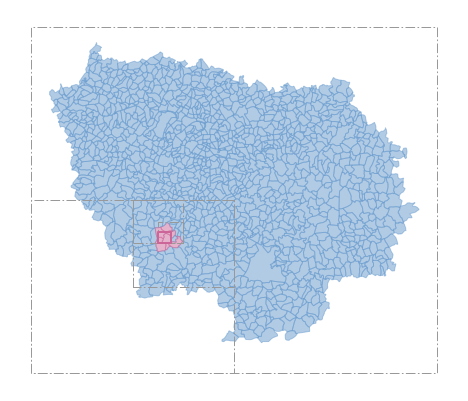

In [10]:
fig = plt.figure(figsize=(15, 7))
ax = fig.gca()

coloured = [commune.name for commune in
            q.children[0].children[3].children[2].children[1].children[0].elements]

msg = "La feuille en question contient {} communes"
print(msg.format(len(coloured)))

for i, s in zip(idf, shapes):
    prop = {'fc': '#6699cc', 'ec': '#6699cc'}
    if i['properties'] in coloured:
        prop = {'fc': '#cc6699', 'ec': '#cc6699'}
    ax.add_patch(PolygonPatch(s, alpha=0.5, zorder=2, **prop))
    
q.plot()
q.children[0].plot()
q.children[0].children[3].plot()
q.children[0].children[3].children[2].plot()
q.children[0].children[3].children[2].children[1].plot()
q.children[0].children[3].children[2].children[1].children[0].plot(color="#cc6699")

# Finitions
ax.axis('scaled')
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

## Tests de performance

On manipule une trajectoire de 1325 points. On va garder dans `through` les communes traversées par la trajectoire. 

In [11]:
traj.shape

(1325, 3)

On compte 4 ms sur un ordinateur de bureau pour trouver la commune survolée par le dernier point de la trajectoire.

In [12]:
%%time
q.match((traj.lamb93_x.values[-1], traj.lamb93_y.values[-1])).name

CPU times: user 2.57 ms, sys: 0 ns, total: 2.57 ms
Wall time: 2.55 ms


OrderedDict([('ID_GEOFLA', 'COMMUNE00000000000032919'),
             ('CODE_COM', '479'),
             ('INSEE_COM', '91479'),
             ('NOM_COM', 'PARAY-VIEILLE-POSTE'),
             ('STATUT', 'Commune simple'),
             ('X_CHF_LIEU', 653111),
             ('Y_CHF_LIEU', 6845527),
             ('X_CENTROID', 652844),
             ('Y_CENTROID', 6847571),
             ('Z_MOYEN', 85),
             ('SUPERFICIE', 606),
             ('POPULATION', 7230),
             ('CODE_CANT', '02'),
             ('CODE_ARR', '3'),
             ('CODE_DEPT', '91'),
             ('NOM_DEPT', 'ESSONNE'),
             ('CODE_REG', '11'),
             ('NOM_REG', 'ILE-DE-FRANCE')])

In [13]:
%%time
through = []
for x_, y_ in zip(traj.lamb93_x, traj.lamb93_y):
    m = q.match((x_, y_))
    if m is not None:
        through.append(m.name)

CPU times: user 2.09 s, sys: 4.57 ms, total: 2.1 s
Wall time: 2.09 s


L'approche naïve pour la trajectoire complète est correcte (moins de 2s). On peut toutefois être plus malin en considérant la temporalité de la trajectoire: si un point survole une commune, il y a de grandes chances que le point suivant survole la même commune:

In [14]:
%%time

through = []
prev = None

for x_, y_ in zip(traj.lamb93_x, traj.lamb93_y):
    if prev is not None:
        if prev.inside(x_, y_):
            continue
    m = q.match((x_, y_))
    if m is not None:
        through.append(m.name)
        prev = m

CPU times: user 812 ms, sys: 1.39 ms, total: 814 ms
Wall time: 797 ms


On peut faire mieux:

- en réduisant encore la taille limite avant subdivision du quadtree;
- en réduisant la résolution des polygones des communes: l'algorithme de [Visvalingam](https://bost.ocks.org/mike/simplify/) fonctionne bien pour cela;
- en changeant de langage de programmation (langage typé/compilé à la C++) et en parallélisant les calculs (duplication du quadtree et parallélisation par batch de trajectoires).

## Affichage des résultats

On reprend la carte précédente pour colorer les communes survolées.

Il faut bien noter que l'algorithme ne colore que les communes survolées par les points enregistrés de la trajectoire. On devine que certaines communes sont survolées sans être colorées; si ce problème est réel sur les données de production, il conviendra certainement d'interpoler la trajectoire à l'endroit où des échantillons manquent.

'ORSONVILLE, PRUNAY-EN-YVELINES, ORSONVILLE, ABLIS, SONCHAMP, PONTHEVRARD, SAINTE-MESME, SAINT-ARNOULT-EN-YVELINES, DOURDAN, SAINT-CYR-SOUS-DOURDAN, LE VAL-SAINT-GERMAIN, SAINT-MAURICE-MONTCOURONNE, SAINT-CHERON, BREUX-JOUY, BREUILLET, SAINT-YON, BOISSY-SOUS-SAINT-YON, EGLY, AVRAINVILLE, GUIBEVILLE, MAROLLES-EN-HUREPOIX, LEUDEVILLE, VERT-LE-GRAND, ECHARCON, LISSES, VILLABE, CORBEIL-ESSONNES, SAINTRY-SUR-SEINE, SAINT-PIERRE-DU-PERRAY, SAVIGNY-LE-TEMPLE, LIEUSAINT, MOISSY-CRAMAYEL, EVRY-GREGY-SUR-YERRE, LIMOGES-FOURCHES, SOIGNOLLES-EN-BRIE, SOLERS, OZOUER-LE-VOULGIS, CHAUMES-EN-BRIE, CHATRES, TOURNAN-EN-BRIE, FAVIERES, PONTCARRE, ROISSY-EN-BRIE, OZOIR-LA-FERRIERE, ROISSY-EN-BRIE, OZOIR-LA-FERRIERE, PONTAULT-COMBAULT, LA QUEUE-EN-BRIE, SUCY-EN-BRIE, BOISSY-SAINT-LEGER, PARAY-VIEILLE-POSTE'

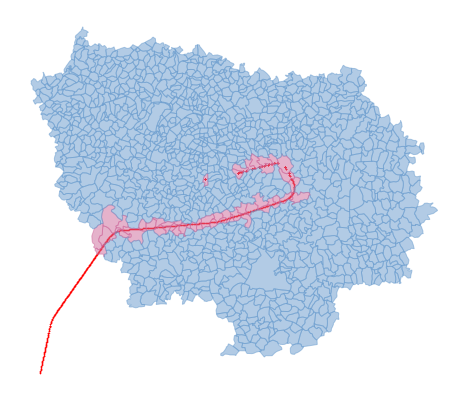

In [15]:
# Pour afficher le résultat, on passe en rouge les communes survolées

fig = plt.figure(figsize=(15, 7))
ax = fig.gca()

for i, s in zip(idf, shapes):
    prop = {'fc': '#6699cc', 'ec': '#6699cc'}
    if i['properties'] in through:
        prop = {'fc': '#cc6699', 'ec': '#cc6699'}
    ax.add_patch(PolygonPatch(s, alpha=0.5, zorder=2, **prop))
    
ax.scatter(traj.lamb93_x, traj.lamb93_y, c='r', s=.2)

# Finitions
bbox = ax.axis('scaled')
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
", ".join(commune['NOM_COM'] for commune in through)

À noter que les dernières communes survolées ne sont pas colorées par manque de points enregistrés en basse altitude sur l'approche finale.